# Analysis of changing seeding density on reprogramming

## Load data
Notes:

1. Singlets

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.ticker import ScalarFormatter
from pathlib import Path
import re
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import rushd as rd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib
no_yellow_viridis = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap('viridis', 256)(np.linspace(0,0.85,256)))


# Required descriptors for annotate
from statannotations.stats.StatTest import StatTest
from scipy.stats import ttest_ind

# Load data

In [2]:
# Directories
base_datadir = rd.datadir/'2024.09.08_seedTitrate_1-2'
figpath = '../figures/fig4/'
# Directories for reps 1, 2
dir12_list = ['2024.09.08_1dpi', '2024.09.09_2dpi', '2024.09.10_3dpi', '2024.09.11_4dpi', '2024.09.12_5dpi', '2024.09.13_6dpi', '2024.09.15_8dpi', '2024.09.17_10dpi', '2024.09.21_14dpi']

# get all csvs for each dir in reps 1, 2
data_all = list()
for (i, dir_name) in enumerate(dir12_list):
    
    # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/'well_metadata_1-2.yaml')
    
    # Get dpi
    match = re.search('.+_(?P<dpi>\d+)dpi', dir_name)
    # If csv is a ctrl file it won't match so ignore
    if match is None:
        continue

    dpi = match.group('dpi')

    df['dpi'] = int(dpi)
    data_all.append(df)

# Convert list of dfs into single df
data_all = pd.concat(data_all, ignore_index=True)
# Remove negative data
data_all = data_all.loc[(data_all['eGFP-A'] > 0)]

# Look at total counts

In [3]:
# Split into counts
group = ['rep', 'cond', 'dpi', 'seedNum_cat',]
# count_df = data_all.groupby([*group, 'well'])['FSC-A'].count().rename('count').reset_index()
count_df_reps = data_all.groupby([*group,'well'])['FSC-A'].count().rename('absolute count')
norm_seedNum = data_all.groupby([*group, 'well'])['seedNum'].mean().rename('seedNum')

count_df_reps = pd.merge(norm_seedNum, count_df_reps, on=[*group,'well'])
count_df_reps['relative count'] = count_df_reps['absolute count'] / count_df_reps['seedNum']
count_df_reps = count_df_reps.reset_index()
count_df_reps['cond_seedNum_cat'] = count_df_reps['cond'] + '_' + count_df_reps['seedNum_cat']

# Collapse bio reps
count_df = count_df_reps.groupby([*group, 'cond_seedNum_cat']).mean().reset_index()

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


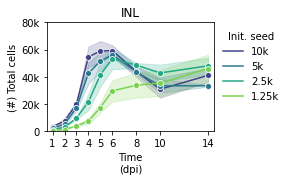

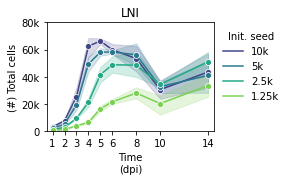

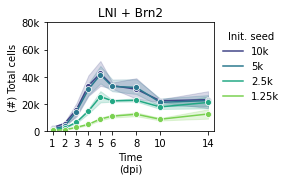

In [4]:
x = 'dpi'
y = 'absolute count'
hue = 'cond_seedNum_cat'
units = 'rep'

for curr_cond in count_df_reps.cond.unique():
    seedNum_order = ['10k', '5k', '2.5k', '1.25k']
    hue_order = [f'{curr_cond}_{seedNum}' for seedNum in seedNum_order]
    # df = count_df[count_df.cond == curr_cond]

    df = count_df_reps[count_df_reps.cond == curr_cond]

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    f = sns.lineplot(data=df, 
        x=x, y=y, hue=hue,
        hue_order=hue_order, # units=units,
        palette='viridis', marker='o',
    )

    # sns.scatterplot(x=xcat, y=ycat, data=data, hue=hue,
    #     palette=pal, hue_order=order) #, style='Experiment'

    # Change limits
    f.set_xticks([1, 2, 3, 4, 5, 6, 8, 10, 14])
    f.set_xlim([0.5, 14.5])
    f.set_ylim([0, 80*10**3])

    # Change labels
    f.set_xlabel('Time\n(dpi)')
    f.set_ylabel('(#) Total cells')
    k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
    ax.yaxis.set_major_formatter(k_formatter)

    # Adjust legend
    lmap = {f'{curr_cond}_{seedNum}':f'{seedNum}' for seedNum in seedNum_order}
    cond_label_map = {'INLx3HA': 'INL', 'LNIx3HA': 'LNI', 'LNIx3HA + Brn2': 'LNI + Brn2'}
    h,l = ax.get_legend_handles_labels()
    sns.move_legend(ax, handles=h, labels=[lmap[i] for i in l],
        title='Init. seed', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    
    plt.title(cond_label_map[curr_cond])

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


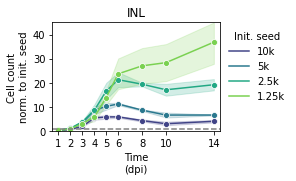

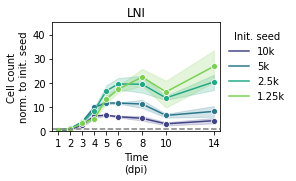

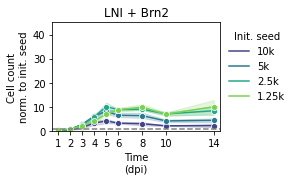

In [5]:
x = 'dpi'
y = 'relative count'
hue = 'cond_seedNum_cat'
units = 'rep'

for curr_cond in count_df_reps.cond.unique():
    seedNum_order = ['10k', '5k', '2.5k', '1.25k']
    hue_order = [f'{curr_cond}_{seedNum}' for seedNum in seedNum_order]

    df = count_df_reps[count_df_reps.cond == curr_cond]

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    f = sns.lineplot(data=df, 
        x=x, y=y, hue=hue,
        hue_order=hue_order, # units=units,
        palette='viridis', marker='o',
    )

    # Add 1 relative line
    ax.axhline(y=1, color='grey', linestyle='--')

    # Change limits
    f.set_xticks([1, 2, 3, 4, 5, 6, 8, 10, 14])
    f.set_xlim([0.5, 14.5])
    f.set_ylim([0, 45])

    # Change labels
    f.set_xlabel('Time\n(dpi)')
    # f.set_ylabel('Relative cell count')
    f.set_ylabel('Cell count\nnorm. to init. seed')

    # Adjust legend
    lmap = {f'{curr_cond}_{seedNum}':f'{seedNum}' for seedNum in seedNum_order}
    cond_label_map = {'INLx3HA': 'INL', 'LNIx3HA': 'LNI', 'LNIx3HA + Brn2': 'LNI + Brn2'}
    h,l = ax.get_legend_handles_labels()
    sns.move_legend(ax, handles=h, labels=[lmap[i] for i in l],
        title='Init. seed', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    
    plt.title(cond_label_map[curr_cond])
    plt.savefig(figpath + f'timeline_count-rel_{curr_cond}.svg', bbox_inches='tight')

# Look at eGFP

## GFP gating

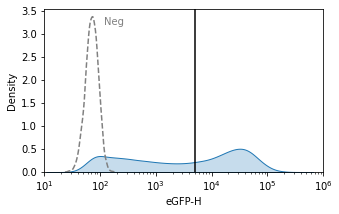

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Threshold for iMNs
eGFP_H_thresh = 5*10**3

# Plot eGFP-H
x = 'eGFP-H'
sns.kdeplot(ax=ax,
    data=data_all.loc[(data_all['rep'] == 1) & (data_all['seedNum_cat'] == '10k') & (data_all['dpi'] == 10) & (data_all['cond'] == 'LNIx3HA')],
    x=x,
    common_norm=False, log_scale=(True, False),
    fill=True)

# Plot neg ctrl
sns.kdeplot(ax=ax,
    data=data_all.loc[(data_all['rep'] == 1) & (data_all['seedNum_cat'] == '10k') & (data_all['dpi'] == 1) & (data_all['cond'] == 'INLx3HA')],
    x=x, common_norm=False, log_scale=(True, False),
    color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.25, 0.9), color='grey', xycoords='axes fraction', ha='center')


# Plot threshold
ax.axvline(eGFP_H_thresh, 0, 1, color='black')

# Adjust limits
eGFP_lim = (10, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)


Count eGFP+

In [7]:
# Categorize eGFP+ based on eGFP_thresh
data_all.loc[:, 'eGFP_cat'] = 'eGFP-'
data_all.loc[(data_all['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'eGFP+'

# Get counts for eGFP +/-
group = ['rep', 'cond', 'dpi', 'seedNum_cat', 'seedNum']
count_GFP_df_reps = data_all.groupby([*group, 'well', 'eGFP_cat'])['FSC-A'].count().unstack(fill_value=0).stack().rename('GFP count') # Puts 0 if no eGFP-H+ rather than dropping row
# Calc eGFP +/- percent and merge with counts
percent_GFP_df_reps = (count_GFP_df_reps*100/count_GFP_df_reps.groupby([*group, 'well']).transform('sum')).dropna().rename('GFP percent')
GFP_df_reps = pd.merge(percent_GFP_df_reps, count_GFP_df_reps, on=[*group, 'well', 'eGFP_cat']).reset_index()
# Calc yield from counts
GFP_df_reps['GFP yield'] = GFP_df_reps['GFP count']/GFP_df_reps['seedNum']*100

# Get just eGFP+
GFP_df_reps = GFP_df_reps.loc[GFP_df_reps.eGFP_cat == 'eGFP+']

# Add cat
GFP_df_reps['cond_seedNum_cat'] = GFP_df_reps['cond'] + '_' + GFP_df_reps['seedNum_cat']

# Add non-GFP count
GFP_df_reps = GFP_df_reps.merge(count_df_reps)
GFP_df_reps['non-GFP count'] = GFP_df_reps['absolute count'] - GFP_df_reps['GFP count']
GFP_df_reps['non-GFP minus GFP count'] = GFP_df_reps['non-GFP count'] - GFP_df_reps['GFP count']

# Calc relative GFP +/- counts
GFP_df_reps['relative GFP count'] = GFP_df_reps['GFP count'] / GFP_df_reps['seedNum']
GFP_df_reps['relative non-GFP count'] = GFP_df_reps['non-GFP count'] / GFP_df_reps['seedNum']
GFP_df_reps['relative non-GFP minus GFP count'] = GFP_df_reps['non-GFP minus GFP count'] / GFP_df_reps['seedNum']

# Collapse to bio reps
y_cats = ['GFP percent', 'GFP count', 'GFP yield', 'non-GFP count', 'non-GFP minus GFP count', 'relative GFP count', 'relative non-GFP count', 'relative non-GFP minus GFP count']
GFP_df = GFP_df_reps.groupby([*group, 'cond_seedNum_cat'])[y_cats].mean().reset_index()

## Yield and percent

Yield

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


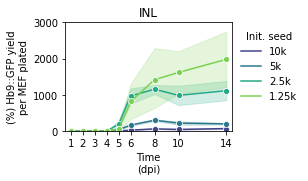

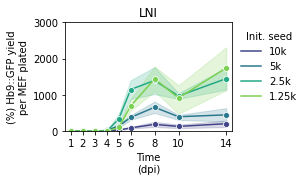

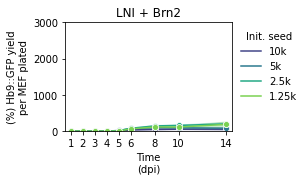

In [8]:
x = 'dpi'
y = 'GFP yield'
hue = 'cond_seedNum_cat'
units = 'rep'

for curr_cond in GFP_df_reps.cond.unique():
    seedNum_order = ['10k', '5k', '2.5k', '1.25k']
    hue_order = [f'{curr_cond}_{seedNum}' for seedNum in seedNum_order]
    # df = count_df[count_df.cond == curr_cond]

    df = GFP_df_reps[GFP_df_reps.cond == curr_cond]

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    f = sns.lineplot(data=df, 
        x=x, y=y, hue=hue,
        hue_order=hue_order, # units=units,
        palette='viridis', marker='o',
    )

    # # Change limits
    f.set_xticks([1, 2, 3, 4, 5, 6, 8, 10, 14])
    f.set_xlim([0.5, 14.5])
    # f.set_yticks(np.arange(0, 500, 100))
    f.set_ylim([0, 3000])

    # Change labels
    f.set_xlabel('Time\n(dpi)')
    f.set_ylabel('(%) Hb9::GFP yield\nper MEF plated')

    # Adjust legend
    lmap = {f'{curr_cond}_{seedNum}':f'{seedNum}' for seedNum in seedNum_order}
    cond_label_map = {'INLx3HA': 'INL', 'LNIx3HA': 'LNI', 'LNIx3HA + Brn2': 'LNI + Brn2'}
    h,l = ax.get_legend_handles_labels()
    sns.move_legend(ax, handles=h, labels=[lmap[i] for i in l],
        title='Init. seed', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    plt.title(cond_label_map[curr_cond])

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


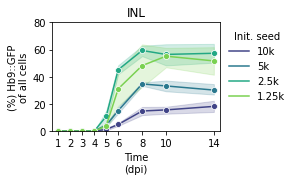

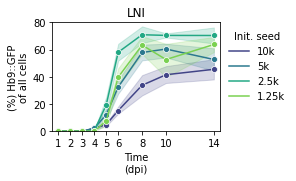

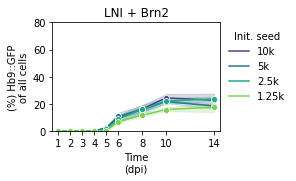

In [9]:
x = 'dpi'
y = 'GFP percent'
hue = 'cond_seedNum_cat'
units = 'rep'

for curr_cond in GFP_df_reps.cond.unique():
    seedNum_order = ['10k', '5k', '2.5k', '1.25k']
    hue_order = [f'{curr_cond}_{seedNum}' for seedNum in seedNum_order]
    # df = count_df[count_df.cond == curr_cond]

    df = GFP_df_reps[GFP_df_reps.cond == curr_cond]

    # Pick colors from no yellow viridis
    palette = sns.color_palette(palette=no_yellow_viridis, n_colors=len(seedNum_order), as_cmap=True)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    f = sns.lineplot(data=df, 
        x=x, y=y, hue=hue,
        hue_order=hue_order, # units=units,
        palette='viridis', marker='o',
    )

    # # Change limits
    f.set_xticks([1, 2, 3, 4, 5, 6, 8, 10, 14])
    f.set_xlim([0.5, 14.5])
    f.set_ylim([0, 80])

    # # Change labels
    f.set_xlabel('Time\n(dpi)')
    f.set_ylabel('(%) Hb9::GFP\nof all cells')
    k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
    ax.yaxis.set_major_formatter(k_formatter)

    # Adjust legend
    lmap = {f'{curr_cond}_{seedNum}':f'{seedNum}' for seedNum in seedNum_order}
    cond_label_map = {'INLx3HA': 'INL', 'LNIx3HA': 'LNI', 'LNIx3HA + Brn2': 'LNI + Brn2'}
    h,l = ax.get_legend_handles_labels()
    sns.move_legend(ax, handles=h, labels=[lmap[i] for i in l],
        title='Init. seed', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    plt.title(cond_label_map[curr_cond])
    
    # plt.savefig(figpath + f'SI/timeline_GFP-percent_{curr_cond}.svg', bbox_inches='tight')

# 14 dpi final bar charts

## Load final 14 dpi data

In [10]:
# Load in 1st set
datadir = rd.datadir/'2024.04.30_HG_seed-titrate-spinfect_14dpi'
df1 = rd.flow.load_csv_with_metadata(datadir/'export_singlets', datadir/'well_metadata.yaml')
df1 = df1[df1.spinfect] # only use + spinfect
df1 = df1.loc[(df1['eGFP-A'] > 0)]

# Load in 2nd set
datadir = rd.datadir/'2024.09.08_seedTitrate_1-2'/'2024.09.21_14dpi_2'
df2 = rd.flow.load_csv_with_metadata(datadir/'export_singlets', datadir/'well_metadata_2.yaml')
df2 = df2.loc[(df2['eGFP-A'] > 0)]

# Load in 3rd set
base_datadir = rd.datadir/'2024.01.26_HG_seed-titrate_14dpi_1-3'
df3 = rd.flow.load_csv_with_metadata(
    base_datadir/'2024.01.26_HG_seed-titrate_14dpi_1'/'export_singlets', base_datadir/'well_metadata_1.yaml')
df3['rep'] = 4
df3 = df3[df3.DDRR_cat] # only use + +DDRR
df3 = df3[ df3['cond'].isin(['LNIx3HA', 'INLx3HA']) ]
df3 = df3.loc[(df3['eGFP-A'] > 0)]

# Concat with just 14 dpi data
data_14dpi = data_all.loc[data_all.dpi == 14]
data_14dpi = pd.concat([data_14dpi, df1, df2, df3])

## Look at eGFP for NILDDRR to determine eGFP gate

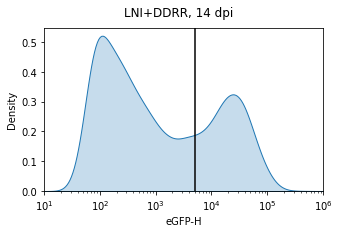

In [ ]:
# Threshold for iMNs
eGFP_H_thresh = 5*10**3

# Downsample to 100,000 cells from NIL
small_data = data_14dpi[(data_14dpi['cond'] == 'LNIx3HA') & (data_14dpi['seedNum_cat'] == '10k') & (data_14dpi['rep'] == 3)].sample(n=10**4, random_state=1)

# Plot eGFP-H
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
x = 'eGFP-H'
sns.kdeplot(data=small_data, x=x,
            ax=ax, log_scale=(True, False), fill=True, common_norm=False)

# Title
plt.suptitle('LNI+DDRR, 14 dpi')
# Adjust limits
eGFP_lim = (10, 10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)
    sub_ax.axvline(eGFP_H_thresh, 0, 1, color='black')

In [12]:
# Categorize iMNs based on eGFP_thresh
data_14dpi.loc[:, 'eGFP_cat'] = 'fib'
data_14dpi.loc[(data_14dpi['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'iMN'

# Get total counts and percent of GFP-H+
group = ['rep', 'cond', 'seedNum_cat', 'seedNum']
count_df_reps = data_14dpi.groupby([*group, 'well', 'eGFP_cat'])['FSC-A'].count().unstack(fill_value=0).stack().rename('iMN count') # Puts 0 if no eGFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*group, 'well']).transform('sum')).dropna().rename('iMN percent')
iMN_df_reps = pd.merge(percent_df_reps, count_df_reps, on=[*group, 'well', 'eGFP_cat']).reset_index()

# Calc yield from counts
iMN_df_reps['iMN yield'] = iMN_df_reps['iMN count']/iMN_df_reps['seedNum']*100
# Extract just the iMNs
iMN_df_reps = iMN_df_reps.loc[(iMN_df_reps['eGFP_cat'] == 'iMN')]
# Collapse to bio reps
iMN_df = iMN_df_reps.groupby([*group]).mean().reset_index()

## Count and yield

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

INLx3HA_10k vs. LNIx3HA_10k: t-test independent samples, P_val:4.184e-02 t=-2.420e+00
LNIx3HA_2.5k vs. LNIx3HA + Brn2_2.5k: t-test independent samples, P_val:6.342e-03 t=4.102e+00
INLx3HA_2.5k vs. LNIx3HA_2.5k: t-test independent samples, P_val:1.552e-01 t=-1.569e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


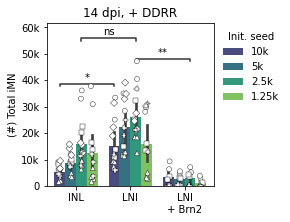

In [25]:
# General plotting params
x = 'cond'
y = 'iMN count'
order = ['INLx3HA', 'LNIx3HA', 'LNIx3HA + Brn2']
marker_list = ['o', 's', '^', 'D', 'P', 'X'] 
units = 'well'

hue = 'seedNum_cat'
hue_order = ['10k', '5k', '2.5k', '1.25k']


fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Barplot
sns.barplot(
    ax=ax, data=iMN_df_reps,
    x=x, y=y, hue=hue,
    order=order, hue_order=hue_order, units=units,
    palette="viridis", alpha=1)

# Stripplot
for (i, rep) in enumerate(iMN_df_reps.rep.unique()):
    sns.stripplot(
        ax=ax,
        data=iMN_df_reps.loc[(iMN_df_reps.rep == rep)],
        x=x, y=y, hue=hue,
        order=order, hue_order=hue_order,
        marker=marker_list[i],
        palette={hue:'white' for hue in hue_order}, size=5, dodge=True,
        edgecolor='black', linewidth=0.4
    )

# Add in stats
pairs = [(('LNIx3HA', '10k'), ('INLx3HA', '10k')), (('LNIx3HA', '2.5k'), ('LNIx3HA + Brn2', '2.5k')), (('LNIx3HA', '2.5k'), ('INLx3HA', '2.5k'))]
annot = Annotator(ax=ax,
    data=iMN_df,
    x=x, y=y, pairs=pairs, hue=hue,
    order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0)

# Format legend
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=l[-len(hue_order):],
    title='Init. seed', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Format axis
k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
ax.set_title('14 dpi, + DDRR')
ax.yaxis.set_major_formatter(k_formatter)
ax.set_xticklabels(['INL', 'LNI', 'LNI\n+ Brn2'])
ax.set_xlabel('')
ax.set_ylabel('(#) Total iMN')
# ax.set_ylim((0, 60*10**3))

# plt.savefig(figpath + '14dpi_iMN_count.svg', bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

INLx3HA_10k vs. LNIx3HA_10k: t-test independent samples, P_val:4.184e-02 t=-2.420e+00
LNIx3HA_2.5k vs. LNIx3HA + Brn2_2.5k: t-test independent samples, P_val:6.342e-03 t=4.102e+00
INLx3HA_2.5k vs. LNIx3HA_2.5k: t-test independent samples, P_val:1.552e-01 t=-1.569e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


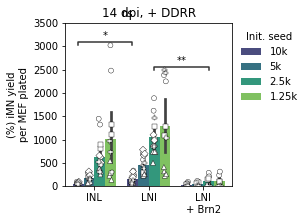

In [ ]:
# General plotting params
x = 'cond'
y = 'iMN yield'
order = ['INLx3HA', 'LNIx3HA', 'LNIx3HA + Brn2']
marker_list = ['o', 's', '^', 'D', 'P', 'X'] 
units = 'well'

hue = 'seedNum_cat'
hue_order = ['10k', '5k', '2.5k', '1.25k']


fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Barplot
sns.barplot(
    ax=ax, data=iMN_df_reps,
    x=x, y=y, hue=hue,
    order=order, hue_order=hue_order, units=units,
    palette="viridis", alpha=1)

# Stripplot
for (i, rep) in enumerate(iMN_df_reps.rep.unique()):
    sns.stripplot(
        ax=ax,
        data=iMN_df_reps.loc[(iMN_df_reps.rep == rep)],
        x=x, y=y, hue=hue,
        order=order, hue_order=hue_order,
        marker=marker_list[i],
        palette={hue:'white' for hue in hue_order}, size=5, dodge=True,
        edgecolor='black', linewidth=0.4
    )

# Add in stats
pairs = [(('LNIx3HA', '10k'), ('INLx3HA', '10k')), (('LNIx3HA', '2.5k'), ('LNIx3HA + Brn2', '2.5k')), (('LNIx3HA', '2.5k'), ('INLx3HA', '2.5k'))]
annot = Annotator(ax=ax,
    data=iMN_df,
    x=x, y=y, pairs=pairs, hue=hue,
    order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0)

# Format legend
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=l[-len(hue_order):],
    title='Init. seed', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Format axis
ax.set_title('14 dpi, + DDRR')
ax.set_xticklabels(['INL', 'LNI', 'LNI\n+ Brn2'])
ax.set_xlabel('')
ax.set_ylabel('(%) iMN yield\nper MEF plated')
ax.set_ylim((0, 3.5e3))

# plt.savefig(figpath + '14dpi_iMN_yield.svg', bbox_inches='tight')

### Plot percent

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

INLx3HA_10k vs. LNIx3HA_10k: t-test independent samples, P_val:4.715e-03 t=-3.874e+00
LNIx3HA_2.5k vs. LNIx3HA + Brn2_2.5k: t-test independent samples, P_val:8.956e-04 t=6.085e+00
INLx3HA_2.5k vs. LNIx3HA_2.5k: t-test independent samples, P_val:2.905e-02 t=-2.655e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


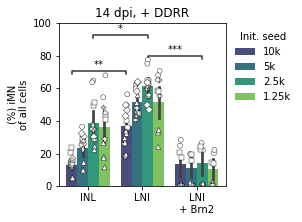

In [ ]:
# General plotting params
x = 'cond'
y = 'iMN percent'
order = ['INLx3HA', 'LNIx3HA', 'LNIx3HA + Brn2']
marker_list = ['o', 's', '^', 'D', 'P', 'X'] 
units = 'well'

hue = 'seedNum_cat'
hue_order = ['10k', '5k', '2.5k', '1.25k']


fig, ax = plt.subplots(1, 1, figsize=(3, 3))

# Barplot
sns.barplot(
    ax=ax, data=iMN_df_reps,
    x=x, y=y, hue=hue,
    order=order, hue_order=hue_order, units=units,
    palette="viridis", alpha=1)

# Stripplot
for (i, rep) in enumerate(iMN_df_reps.rep.unique()):
    sns.stripplot(
        ax=ax,
        data=iMN_df_reps.loc[(iMN_df_reps.rep == rep)],
        x=x, y=y, hue=hue,
        order=order, hue_order=hue_order,
        marker=marker_list[i],
        palette={hue:'white' for hue in hue_order}, size=5, dodge=True,
        edgecolor='black', linewidth=0.4
    )

# Add in stats
pairs = [(('LNIx3HA', '10k'), ('INLx3HA', '10k')), (('LNIx3HA', '2.5k'), ('LNIx3HA + Brn2', '2.5k')), (('LNIx3HA', '2.5k'), ('INLx3HA', '2.5k'))]
annot = Annotator(ax=ax,
    data=iMN_df,
    x=x, y=y, pairs=pairs, hue=hue,
    order=order, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.01)

# Format legend
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[-len(hue_order):], labels=l[-len(hue_order):],
    title='Init. seed', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Format axis
ax.set_title('14 dpi, + DDRR')
ax.set_xticklabels(['INL', 'LNI', 'LNI\n+ Brn2'])
ax.set_xlabel('')
ax.set_ylabel('(%) iMN\nof all cells')
ax.set_ylim((0, 100))

# plt.savefig(figpath + '14dpi_iMN-purity.svg', bbox_inches='tight')

# Staining data

## Load data

In [18]:
# Directories
datadir_stain = rd.datadir/'2024.09.16_seedTitrate-stain_4dpi'

# Load main data
data_stain = list()
files = Path(datadir_stain / 'export_singlets-DAPI').glob('*.csv') 
for i, file in enumerate(files):

    # Extract metadata from csv title
    regex = 'export_(?P<cond>.+)_(?P<seedNum>.+)k_rep(?P<rep>\d)_(?P<subpop>.+).csv'
    match = re.search(regex , file.name)

    # If no match, check if control
    if match is None:
        print('No match for {}'.format(file.name))
        continue

    # Load as df and note header is on 0th row
    df = pd.read_csv(file, header=0)

    # Update columns in df with metadata from file name
    df['cond'] = match.group('cond')
    seedNum = match.group('seedNum')
    df['seedNum'] = float(seedNum)*10**3
    df['seedNum_cat'] = f'{seedNum}k'
    df['rep'] = int(match.group('rep'))

    data_stain.append(df)

data_stain = pd.concat(data_stain, ignore_index=True)

# Load ctrl data
data_stain_ctrl = list()
files = Path(datadir_stain / 'export_singlets').glob('*.csv') 
for i, file in enumerate(files):

    # Extract metadata from csv title
    regex = 'export_Ctrl-(?P<cond>.+)_(?P<subpop>.+).csv'
    match = re.search(regex , file.name)

    # If no match, keep going
    if match is None:
        # print('No match for {}'.format(file.name))
        continue

    # Load as df and note header is on 0th row
    df = pd.read_csv(file, header=0)

    # Update columns in df with metadata from file name
    df['cond'] = 'Ctrl-{}'.format(match.group('cond'))

    data_stain_ctrl.append(df)

data_stain_ctrl = pd.concat(data_stain_ctrl, ignore_index=True)



# Remove negative data
data_stain = data_stain.loc[
    (data_stain['Alexa Fluor™ 647-H'] > 0) &
    (data_stain['eGFP-H'] > 0) &
    (data_stain['mRuby2-H'] > 0) &
    (data_stain['DAPI-H'] > 0)
]
data_stain_ctrl = data_stain_ctrl.loc[
    (data_stain_ctrl['Alexa Fluor™ 647-H'] > 0) &
    (data_stain_ctrl['eGFP-H'] > 0) &
    (data_stain_ctrl['mRuby2-H'] > 0) &
    (data_stain_ctrl['DAPI-H'] > 0)
]

Ctrls

Text(0.5, 0, 'Ngn2$^{x3HA}$ (Alexa Fluor™ 647)')

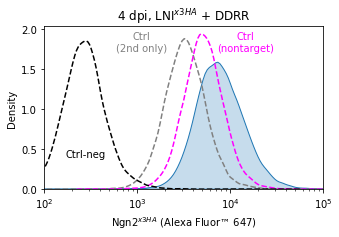

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plottting parameters
x = 'Alexa Fluor™ 647-H'
seedNum_cat = '10k'
cond = 'LNIx3HA'

# Plot actual stain
sns.kdeplot(data=data_stain.loc[
    (data_stain['cond'] == cond) & (data_stain['seedNum_cat'] == seedNum_cat)],
    ax=ax, x=x,
    common_norm=False, log_scale=(True, False),
    fill=True)


# Plot 2nd ctrl
sns.kdeplot(data=data_stain_ctrl[(data_stain_ctrl['cond'] == 'Ctrl-secondary')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Ctrl\n(2nd only)', (0.35, 0.85), color='grey' , xycoords='axes fraction', ha='center')

# Plot 2nd ctrl
sns.kdeplot(data=data_stain_ctrl[(data_stain_ctrl['cond'] == 'Ctrl-RIDDsecondary')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='magenta', fill=False, linestyle='--')
ax.annotate('Ctrl\n(nontarget)', (0.72, 0.85), color='magenta' , xycoords='axes fraction', ha='center')

# Plot neg ctrl
sns.kdeplot(data=data_stain_ctrl[(data_stain_ctrl['cond'] == 'Ctrl-neg')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='black', fill=False, linestyle='--')
ax.annotate('Ctrl-neg', (0.15, 0.2), color='black', xycoords='axes fraction', ha='center')

# Title
plt.title('4 dpi, LNI$^{x3HA}$ + DDRR')
# Adjust limits
AF_lim = (1e2, 1e5)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(AF_lim)

ax.set_xlabel('Ngn2$^{x3HA}$ (Alexa Fluor™ 647)')

## Threshold based on DAPI for n or 2n

### Before threshold

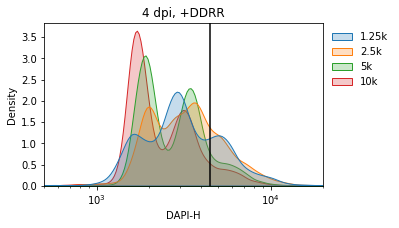

In [20]:
# Plottting parameters
x = 'DAPI-H'
cond = 'INLx3HA'
hue = 'seedNum_cat'
hue_order = ['1.25k', '2.5k', '5k', '10k']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.kdeplot(data=data_stain.loc[
    (data_stain['cond'] == cond)],
    ax=ax, x=x, hue=hue,
    common_norm=False, log_scale=(True, False), hue_order=hue_order,
    fill=True)

# Set threshold
DAPI_H_thresh = 4.5e3
ax.axvline(DAPI_H_thresh, color='black')

# Format
plt.title('4 dpi, +DDRR')
DAPI_lim = (5e2, 2e4)
ax.set_xlim(DAPI_lim)
sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)


Text(0.5, 0.98, 'LNIx3HA+Brn2')

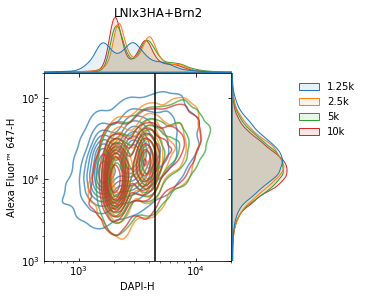

In [21]:
# What to plot
x = "DAPI-H"
y='Alexa Fluor™ 647-H'
hue = 'seedNum_cat'
hue_order = ['1.25k', '2.5k', '5k', '10k']

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# Set up figure
fig = plt.figure(figsize=(4, 4))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.set_axis_off()
ax_histy = plt.axes(rect_histy)
ax_histy.set_axis_off()

# Set limits
DAPI_lim = (5e2, 2e4)
stain_lim = (1e3, 2e5)
xlim = DAPI_lim
ylim = stain_lim
ax_scatter.set_xlim(xlim)
ax_scatter.set_ylim(ylim)
ax_histx.set_xlim(xlim)
ax_histy.set_ylim(ylim)

# Just look at INL
cond = 'LNIx3HA+Brn2'
small_data = data_stain[(data_stain['cond'] == cond)]
# small_data = small_data.sample(n=1000)

# Make density plots
sns.kdeplot(ax=ax_scatter, data=small_data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=0.7,
            log_scale=True, common_norm=False, fill=False, legend=False)

# Plot histograms
sns.kdeplot(ax=ax_histx, data=small_data, x=x, hue=hue, hue_order=hue_order, alpha=0.1,
            log_scale=True, fill=True, common_norm=False, legend=False)
sns.kdeplot(ax=ax_histy, data=small_data, y=y, hue=hue, hue_order=hue_order, alpha=0.1,
            log_scale=True, fill=True, common_norm=False, legend=True)

sns.move_legend(ax_histy, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

ax_scatter.axvline(DAPI_H_thresh, color='black')

fig.suptitle(cond)

### After threshold

Text(0.5, 0.98, 'LNIx3HA+Brn2')

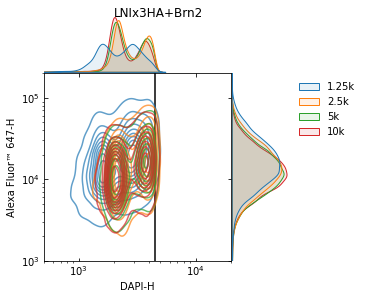

In [22]:
# What to plot
x = "DAPI-H"
y='Alexa Fluor™ 647-H'
hue = 'seedNum_cat'
hue_order = ['1.25k', '2.5k', '5k', '10k']

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# Set up figure
fig = plt.figure(figsize=(4, 4))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.set_axis_off()
ax_histy = plt.axes(rect_histy)
ax_histy.set_axis_off()

# Set limits
DAPI_lim = (5e2, 2e4)
stain_lim = (1e3, 2e5)
xlim = DAPI_lim
ylim = stain_lim
ax_scatter.set_xlim(xlim)
ax_scatter.set_ylim(ylim)
ax_histx.set_xlim(xlim)
ax_histy.set_ylim(ylim)

# Just look at INL
cond = 'LNIx3HA+Brn2'
# Threshold DAPI!
small_data = data_stain[(data_stain['cond'] == cond) & (data_stain['DAPI-H'] < DAPI_H_thresh)]
ax_scatter.axvline(DAPI_H_thresh, color='black')

# Make density plots
sns.kdeplot(ax=ax_scatter, data=small_data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=0.7,
            log_scale=True, common_norm=False, fill=False, legend=False)

# Plot histograms
sns.kdeplot(ax=ax_histx, data=small_data, x=x, hue=hue, hue_order=hue_order, alpha=0.1,
            log_scale=True, fill=True, common_norm=False, legend=False)
sns.kdeplot(ax=ax_histy, data=small_data, y=y, hue=hue, hue_order=hue_order, alpha=0.1,
            log_scale=True, fill=True, common_norm=False, legend=True)

sns.move_legend(ax_histy, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

fig.suptitle(cond)

## Mean levels

### Mean after threshold

Normalize staining

In [23]:
# x = 'Alexa Fluor™ 647-A'
x = 'Alexa Fluor™ 647-H'

# Threshold
data_stain_thresh = data_stain.loc[(data_stain['DAPI-H'] < DAPI_H_thresh)]

# Calculate mean of each sample
well_group = ['cond', 'rep', 'seedNum_cat', 'seedNum']
data_stain_thresh_mean = data_stain_thresh.groupby(
        well_group)[x].apply(scipy.stats.gmean).reset_index(name=x+' (gmean)')

# For violin plots, first log10 transform data
data_stain_thresh['log({})'.format(x)] = np.log10(data_stain_thresh[x])
data_stain_thresh_mean['log({})'.format(x+' (gmean)')] = np.log10(data_stain_thresh_mean[x+' (gmean)'])

# Normalize to INL in log10 space for each rep
rep_list = data_stain_thresh_mean['rep'].unique()

for (i, rep) in enumerate(rep_list):

        base = data_stain_thresh_mean.loc[
            (data_stain_thresh_mean.cond == 'INLx3HA') &
            (data_stain_thresh_mean.seedNum_cat == '10k') &
            (data_stain_thresh_mean.rep == rep)]['log({})'.format(x+' (gmean)')].mean()

        data_stain_thresh.loc[(data_stain_thresh.rep==rep), 'Norm log({})'.format(x)] = \
            data_stain_thresh[(data_stain_thresh.rep==rep)]['log({})'.format(x)] - base + 1

        data_stain_thresh_mean.loc[(data_stain_thresh_mean.rep==rep), 'Norm log({})'.format(x+' (gmean)')] = \
            data_stain_thresh_mean[(data_stain_thresh_mean.rep==rep)]['log({})'.format(x+' (gmean)')] - base + 1 

/var/folders/2d/h4qyrjcd68x7g4p2qdv30s8h0000gn/T/ipykernel_20314/3180179985.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_stain_thresh['log({})'.format(x)] = np.log10(data_stain_thresh[x])
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/pandas/core/indexing.py

/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


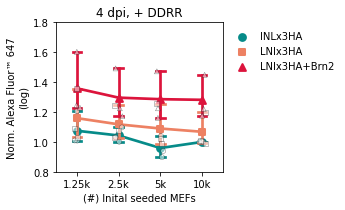

In [ ]:
# Plotting params
x = 'seedNum_cat'
y = 'Alexa Fluor™ 647-H'
hue = 'cond'

order = ['1.25k', '2.5k', '5k', '10k']
hue_order = ['INLx3HA', 'LNIx3HA', 'LNIx3HA+Brn2']
marker_list = ['o', 's', '^', 'D', 'P', 'X']

palette = {'INLx3HA': '#068B89', 'LNIx3HA': '#ED8163', 'LNIx3HA+Brn2': 'crimson'}

fig, ax = plt.subplots(1, 1, figsize=(3, 2.75))

# Plot well geometric means for +/-DDRR
sns.pointplot(ax=ax,
    data=data_stain_thresh_mean, 
    x=x, y='Norm log({})'.format(y+' (gmean)'), hue=hue, 
    order=order, hue_order=hue_order,
    linewidth=0.5, errorbar='se', capsize=.2,
    palette=palette, markers=marker_list, height=4)

for (i, curr_hue) in enumerate(hue_order):
    sns.stripplot(ax=ax,
        data=data_stain_thresh_mean[data_stain_thresh_mean[hue] == curr_hue],
        x=x, y='Norm log({})'.format(y+' (gmean)'),
        order=order, hue_order=hue_order,
        dodge=False, marker=marker_list[i],
        color='white', size=5, 
        edgecolor='black', linewidth=0.5, alpha=0.5)

# Move legend
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax, handles=h[:-len(hue_order)], labels=l[:-len(hue_order)],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Label
ax.set_ylabel('Norm. Alexa Fluor™ 647\n(log)')
plt.title('4 dpi, + DDRR')

ax.set_xlabel('(#) Inital seeded MEFs')


# Adjust labels
for sub_ax in plt.gcf().get_axes():
    # sub_ax.set_xticks(np.arange(0.8, 1.9, 0.2))
    sub_ax.set_ylim((0.8, 1.8)) # Trim x axis


fig.tight_layout()  # Helps improve white spacing
plt.savefig(figpath + 'SI/4dpi-stain_ptplot_threshold.svg', bbox_inches='tight')